In [ ]:
# conda activate streamlit_resale_flat_prices

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st

In [2]:
# read data
data = pd.read_csv(r'flat_prices_full.csv')

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

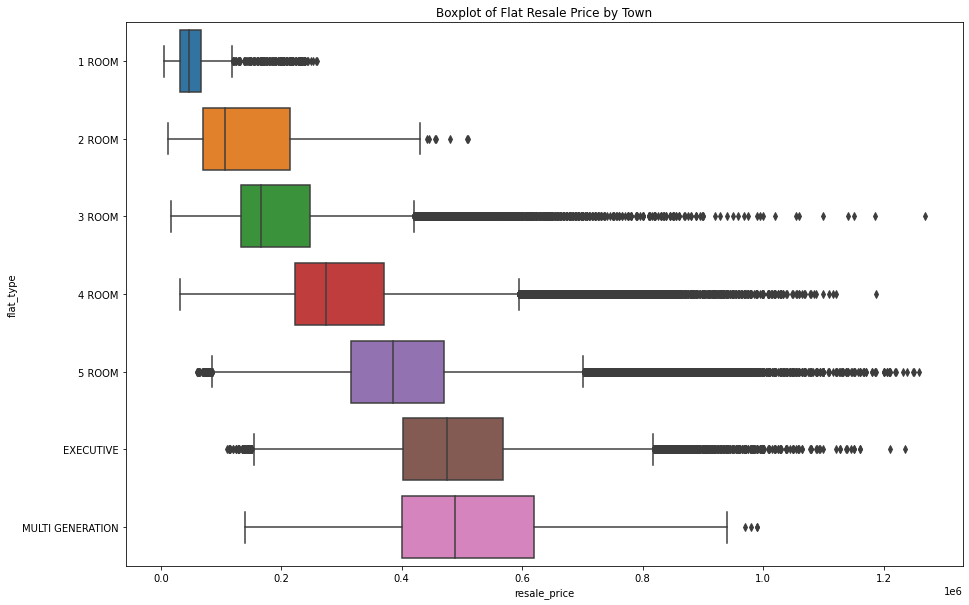

In [24]:
# set plot and figure size
fig, ax = plt.subplots(figsize=(15,10))

# plot ax
ax = sns.boxplot(x='resale_price', y='flat_type', data=data, order=sorted(list(data['flat_type'].unique())))

# set title
ax.set_title('Boxplot of Flat Resale Price by Town')
# show plot
st.pyplot(fig)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

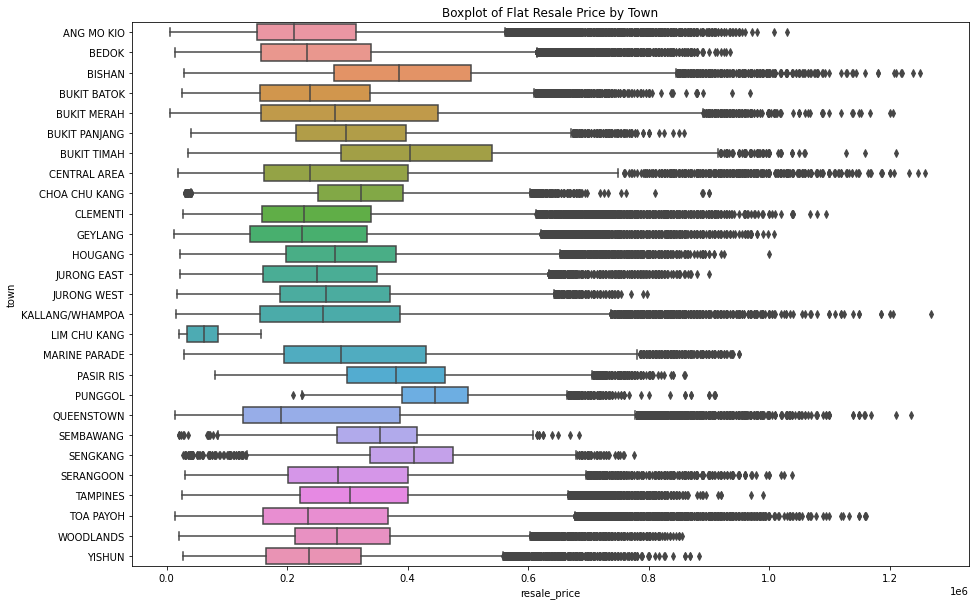

In [25]:
# set plot and figure size
fig, ax = plt.subplots(figsize=(15,10))

# plot boxplot
sns.boxplot(x='resale_price', y='town', data=data, order=sorted(list(data['town'].unique())))

# set title
ax.set_title('Boxplot of Flat Resale Price by Town')
# show ploy
st.pyplot(fig)

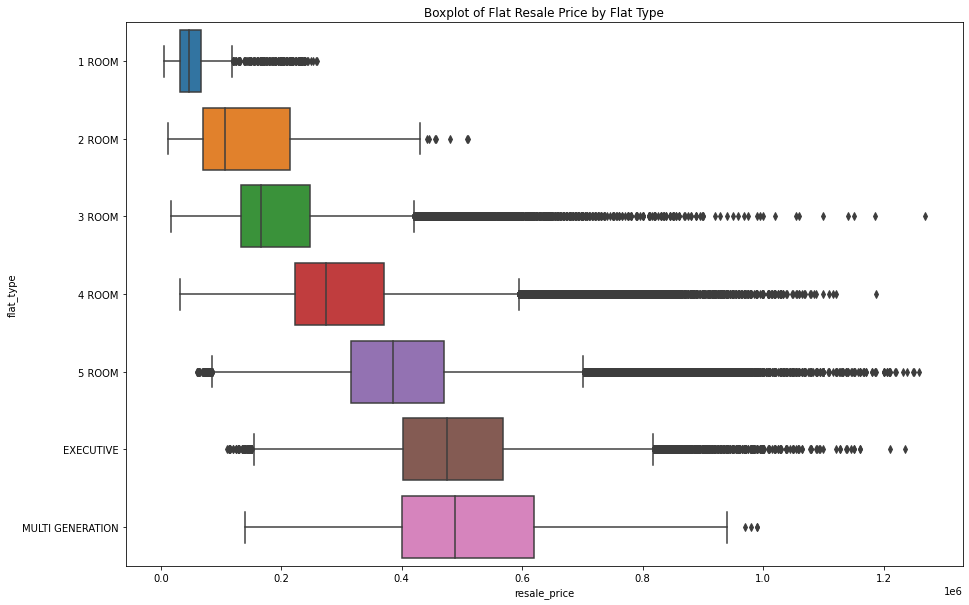

In [12]:
# set size of plot
plt.figure(figsize=(15,10))

# plot boxplot
sns.boxplot(x='resale_price', y='flat_type', data=data, order=sorted(list(data['flat_type'].unique())))

# set title
plt.title('Boxplot of Flat Resale Price by Flat Type')
# show
plt.show()

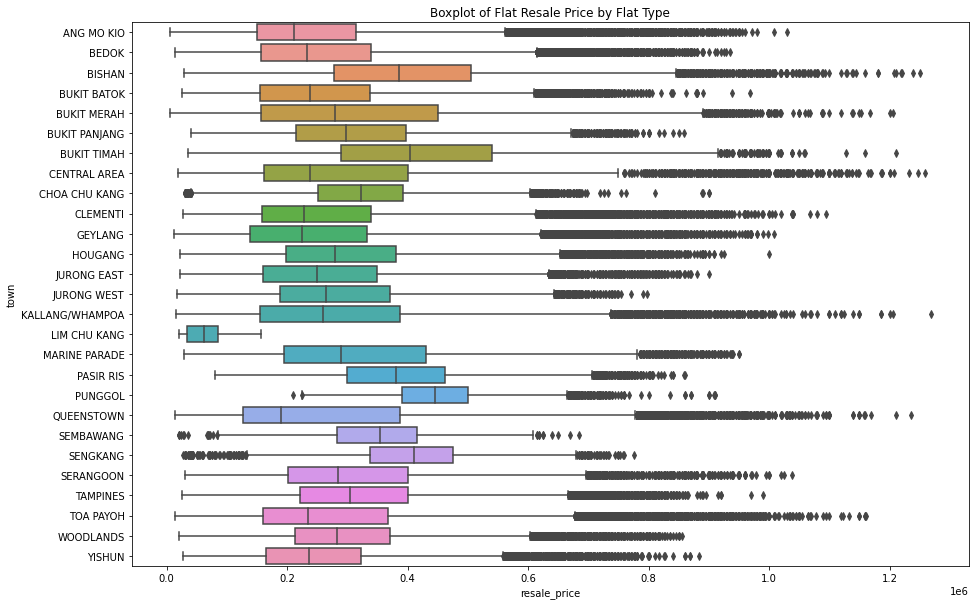

In [13]:
# set size of plot
plt.figure(figsize=(15,10))

# plot boxplot
sns.boxplot(x='resale_price', y='town', data=data, order=sorted(list(data['town'].unique())))

# set title
plt.title('Boxplot of Flat Resale Price by Town')
# show
plt.show()